## Preprocessing - Adversial Debiasing  -  Compas Model
- for 'sex' and 'race'

In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.insert(0, project_root)

import tensorflow.compat.v1 as tf
from tensorflow.compat.v1 import reset_default_graph
import pandas as pd
from src.data_loading import load_compas_sex, load_compas_race
from src.modeling import adversial_debiasing_train_and_predict
from src.metrics import compute_metrics, viz_metrics_2x3, compare_viz_metrics_2x3
from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.datasets import BinaryLabelDataset
from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd


/opt/anaconda3/lib/python3.11/site-packages/inFairness/utils/ndcg.py:37: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  vect_normalized_discounted_cumulative_gain = vmap(
/opt/anaconda3/lib/python3.11/site-packages/inFairness/utils/ndcg.py:48: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  monte_carlo_vect_ndcg = vmap(vect_normalized_di

## Build up the function using race

In [ ]:
# 1) Retrieve data
protected           = 'race'
privileged_value    = 0.0
unprivileged_value  = 1.0
privileged_groups   = [{protected: privileged_value}]
unprivileged_groups = [{protected: unprivileged_value}]

ds, df = load_compas_race()  
feature_cols = [c for c in df.columns if c not in ('label','race')]

# 2) Run experiment, Evaluate
sss = StratifiedShuffleSplit(n_splits=25, test_size=0.2, random_state=42)

results = []
for i, (train_idx, test_idx) in enumerate(sss.split(df, df['label'])):
    # Reset TF graph - start new session (to avoid "Variable … already exists")
    reset_default_graph()
    sess = tf.Session()

    train_df = df.iloc[train_idx].reset_index(drop=True)
    test_df  = df.iloc[test_idx].reset_index(drop=True)

    # Wrap into AIF360 
    train_bld = BinaryLabelDataset(
        df=train_df,
        label_names=['label'],
        protected_attribute_names=[protected],
        favorable_label=1.0,
        unfavorable_label=0.0,
        privileged_protected_attributes=[[privileged_value]],
        unprivileged_protected_attributes=[[unprivileged_value]]
    )
    test_bld = BinaryLabelDataset(
        df=test_df,
        label_names=['label'],
        protected_attribute_names=[protected],
        favorable_label=1.0,
        unfavorable_label=0.0,
        privileged_protected_attributes=[[privileged_value]],
        unprivileged_protected_attributes=[[unprivileged_value]]
    )

    # Instantiate & train AdversarialDebiasing
    adv = AdversarialDebiasing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        scope_name='adv',             
        debias=True,
        sess=sess
    )
    adv.fit(train_bld)

    # Predict on test split
    pred_bld = adv.predict(test_bld)
    y_test   = test_df['label'].values
    y_pred   = pred_bld.labels.ravel()

    # Compute & store metrics
    m = compute_metrics(
        test_df, y_test, y_pred,
        protected, privileged_value, unprivileged_value
    )
    results.append(m)

    sess.close()

compas_race_metrics = pd.DataFrame(results)
compas_race_metrics_agg = compas_race_metrics.agg(['mean','std'])

print(compas_race_metrics_agg)

## refactor function

In [8]:
# 1) Retrieve data
protected           = 'race'
privileged_value    = 0.0
unprivileged_value  = 1.0
privileged_groups   = [{protected: privileged_value}]
unprivileged_groups = [{protected: unprivileged_value}]

tf.disable_v2_behavior()
ds, df = load_compas_race()  
feature_cols = [c for c in df.columns if c not in ('label','race')]

# 2) Run experiment, Evaluate
sss = StratifiedShuffleSplit(n_splits=25, test_size=0.2, random_state=42)

results = []
for i, (train_idx, test_idx) in enumerate(sss.split(df, df['label'])):
    test_df, y_test, y_pred = adversial_debiasing_train_and_predict(
    df,
    train_idx,
    test_idx,
    protected,
    privileged_value,
    unprivileged_value,
    privileged_groups,
    unprivileged_groups,
    scope_name='adv',           
    num_epochs=50,
    batch_size=128,
    adversary_loss_weight=0.1)
    
    m = compute_metrics(
        test_df, y_test, y_pred,
        protected, privileged_value, unprivileged_value
    )
    results.append(m)

compas_race_metrics = pd.DataFrame(results)
compas_race_metrics_agg = compas_race_metrics.agg(['mean','std'])

print(compas_race_metrics_agg)

epoch 0; iter: 0; batch classifier loss: 1.159293; batch adversarial loss: 0.690503
epoch 1; iter: 0; batch classifier loss: 0.782215; batch adversarial loss: 0.654781
epoch 2; iter: 0; batch classifier loss: 0.672105; batch adversarial loss: 0.660975
epoch 3; iter: 0; batch classifier loss: 0.729767; batch adversarial loss: 0.669023
epoch 4; iter: 0; batch classifier loss: 0.667433; batch adversarial loss: 0.667298
epoch 5; iter: 0; batch classifier loss: 0.668472; batch adversarial loss: 0.638299
epoch 6; iter: 0; batch classifier loss: 0.621691; batch adversarial loss: 0.634494
epoch 7; iter: 0; batch classifier loss: 0.628154; batch adversarial loss: 0.608024
epoch 8; iter: 0; batch classifier loss: 0.645674; batch adversarial loss: 0.611324
epoch 9; iter: 0; batch classifier loss: 0.624584; batch adversarial loss: 0.612130
epoch 10; iter: 0; batch classifier loss: 0.638072; batch adversarial loss: 0.626806
epoch 11; iter: 0; batch classifier loss: 0.623287; batch adversarial loss:

In [4]:
baseline_race_agg = pd.read_csv('../../reports/baseline_agg/compas_race_metrics_agg.csv', index_col=0)
baseline_sex_agg = pd.read_csv('../../reports/baseline_agg/compas_sex_metrics_agg.csv', index_col=0)

In [5]:
baseline_race_agg

,accuracy,f1_score,SPD,DI,EOD,AOD
mean,0.673070,0.597067,-0.179721,0.575375,-0.208976,-0.159877
std,0.010989,0.012907,0.024342,0.048820,0.038348,0.023623


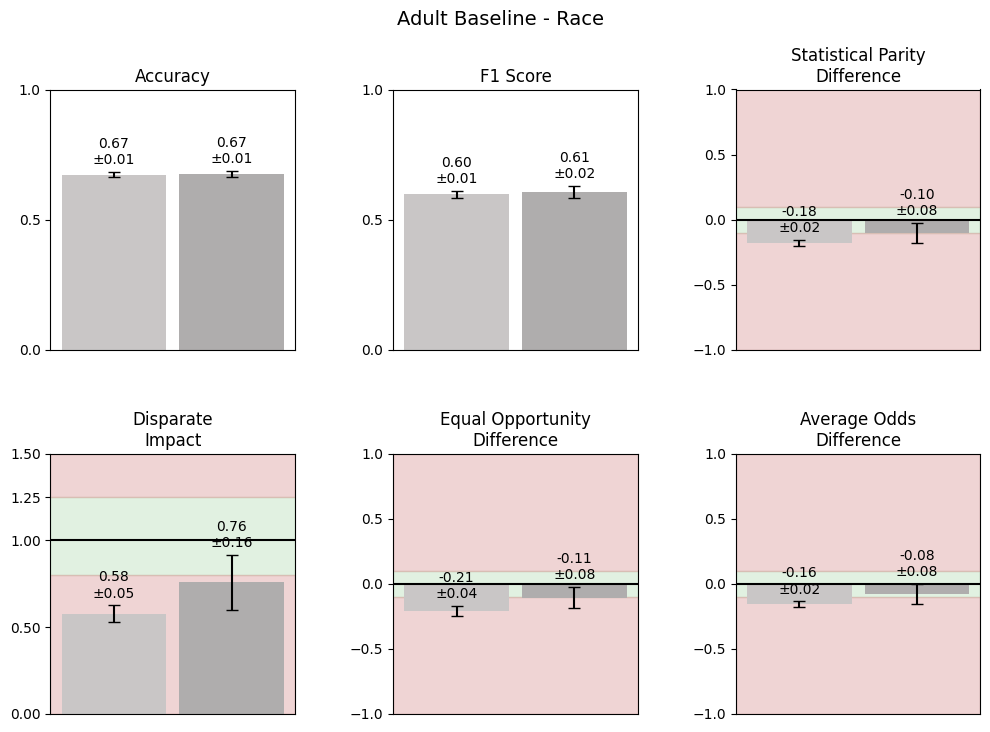

In [6]:
compare_viz_metrics_2x3(baseline_race_agg, compas_race_metrics_agg, 'Baseline', 'Race', 'Adult Baseline - Race')

## Hyperparametersearch

In [35]:
from sklearn.model_selection import ParameterGrid
import pandas as pd

# 1) Define the hyperparameter grid
param_grid = {
    'adversary_loss_weight': [0.5, 1.0],
    'num_epochs':            [10,20, 50],
    'batch_size':            [64, 128]
}
grid = list(ParameterGrid(param_grid))

# 2) Prepare to collect results
grid_results = []

# each hyperparam setting
for params in grid:
    print(f"Testing config: {params}")
    fold_metrics = []
    
    sss = StratifiedShuffleSplit(n_splits=25, test_size=0.2, random_state=42)

    for train_idx, test_idx in sss.split(df, df['label']):
        test_df, y_test, y_pred = adversial_debiasing_train_and_predict(
            df, train_idx, test_idx,
            protected, privileged_value, unprivileged_value,
            privileged_groups, unprivileged_groups,
            scope_name='adv',
            num_epochs=params['num_epochs'],
            batch_size=params['batch_size'],
            adversary_loss_weight=params['adversary_loss_weight']
        )
        m = compute_metrics(
            test_df, y_test, y_pred,
            protected, privileged_value, unprivileged_value
        )
        fold_metrics.append(m)
    
    df_fm = pd.DataFrame(fold_metrics)
    agg = df_fm.agg(['mean','std'])
    
    grid_results.append({
        **params,
        'acc_mean':   agg.loc['mean','accuracy'],
        'acc_std':    agg.loc['std', 'accuracy'],
        'f1_mean':    agg.loc['mean','f1_score'],
        'f1_std':     agg.loc['std', 'f1_score'],
        'SPD_mean':   agg.loc['mean','SPD'],
        'SPD_std':    agg.loc['std', 'SPD'],
        'DI_mean':    agg.loc['mean','DI'],
        'DI_std':     agg.loc['std', 'DI'],
        'EOD_mean':   agg.loc['mean','EOD'],
        'EOD_std':    agg.loc['std', 'EOD'],
        'AOD_mean':   agg.loc['mean','AOD'],
        'AOD_std':    agg.loc['std', 'AOD'],
    })

results_df = pd.DataFrame(grid_results)

Testing config: {'adversary_loss_weight': 0.5, 'batch_size': 64, 'num_epochs': 10}
epoch 0; iter: 0; batch classifier loss: 0.868324; batch adversarial loss: 0.734267
epoch 1; iter: 0; batch classifier loss: 0.615880; batch adversarial loss: 0.689703
epoch 2; iter: 0; batch classifier loss: 0.710942; batch adversarial loss: 0.685206
epoch 3; iter: 0; batch classifier loss: 0.628448; batch adversarial loss: 0.691558
epoch 4; iter: 0; batch classifier loss: 0.676692; batch adversarial loss: 0.650701
epoch 5; iter: 0; batch classifier loss: 0.786493; batch adversarial loss: 0.715083
epoch 6; iter: 0; batch classifier loss: 0.611823; batch adversarial loss: 0.690692
epoch 7; iter: 0; batch classifier loss: 0.681624; batch adversarial loss: 0.662618
epoch 8; iter: 0; batch classifier loss: 0.625748; batch adversarial loss: 0.701866
epoch 9; iter: 0; batch classifier loss: 0.584952; batch adversarial loss: 0.632024
epoch 0; iter: 0; batch classifier loss: 1.111967; batch adversarial loss: 0.

In [29]:
results_df

,adversary_loss_weight,batch_size,num_epochs,acc_mean,acc_std,f1_mean,f1_std,SPD_mean,SPD_std,DI_mean,DI_std,EOD_mean,EOD_std,AOD_mean,AOD_std
0,0.5,64,10,0.686071,NaN,0.649652,NaN,-0.417483,NaN,0.287824,NaN,-0.429136,NaN,-0.385527,NaN
1,0.5,64,20,0.671518,NaN,0.600337,NaN,-0.057471,NaN,0.852941,NaN,-0.046543,NaN,-0.022434,NaN
2,0.5,64,50,0.676369,NaN,0.578900,NaN,-0.066985,NaN,0.803359,NaN,-0.064750,NaN,-0.033504,NaN
3,0.5,128,10,0.539848,NaN,0.587065,NaN,-0.997942,NaN,0.002058,NaN,-0.994413,NaN,-0.997207,NaN
4,0.5,128,20,0.610534,NaN,0.639744,NaN,0.252899,NaN,1.463649,NaN,0.135561,NaN,0.264132,NaN
5,0.5,128,50,0.673597,NaN,0.597092,NaN,-0.073835,NaN,0.807988,NaN,-0.077939,NaN,-0.041131,NaN
6,1.0,64,10,0.642412,NaN,0.638655,NaN,0.083678,NaN,1.163763,NaN,0.041822,NaN,0.109516,NaN
7,1.0,64,20,0.654193,NaN,0.540938,NaN,-0.040894,NaN,0.870839,NaN,-0.022845,NaN,-0.009723,NaN
8,1.0,64,50,0.662509,NaN,0.589722,NaN,0.046970,NaN,1.131820,NaN,0.027874,NaN,0.076667,NaN
9,1.0,128,10,0.530146,NaN,0.471139,NaN,0.804004,NaN,5.808951,NaN,0.708015,NaN,0.803770,NaN


In [34]:
# thresholds fairness
di_min, di_max        = 0.8, 1.25
spd_thresh, eod_thresh, aod_thresh = 0.1, 0.1, 0.1

# filter for configs that satisfy ALL four fairness bounds
fair_configs = results_df[
    (results_df['DI_mean']  >= di_min)  & (results_df['DI_mean']  <= di_max)   &
    (results_df['SPD_mean'].abs() <= spd_thresh)                              &
    (results_df['EOD_mean'].abs() <= eod_thresh)                              &
    (results_df['AOD_mean'].abs() <= aod_thresh)
]

fair_configs[['adversary_loss_weight','num_epochs','batch_size',
                    'SPD_mean','DI_mean','EOD_mean','AOD_mean',
                    'acc_mean']]

,adversary_loss_weight,num_epochs,batch_size,SPD_mean,DI_mean,EOD_mean,AOD_mean,acc_mean
1,0.5,20,64,-0.057471,0.852941,-0.046543,-0.022434,0.671518
2,0.5,50,64,-0.066985,0.803359,-0.064750,-0.033504,0.676369
5,0.5,50,128,-0.073835,0.807988,-0.077939,-0.041131,0.673597
7,1.0,20,64,-0.040894,0.870839,-0.022845,-0.009723,0.654193
8,1.0,50,64,0.046970,1.131820,0.027874,0.076667,0.662509
11,1.0,50,128,-0.030787,0.922056,-0.040399,0.001211,0.669439


In [ ]:
from sklearn.model_selection import StratifiedKFold
folds = StratifiedKFold(n_splits=25, shuffle=True, random_state=42)
metrics = []
for train_idx, test_idx in folds.split(df, df['label']):
    test_df, y_test, y_pred = adversial_debiasing_train_and_predict(
        df, train_idx, test_idx,
        protected, privileged_value, unprivileged_value,
        privileged_groups, unprivileged_groups,
        scope_name='adv',
        num_epochs=50,
        batch_size=64,
        adversary_loss_weight=1.0
    )
    m = compute_metrics(test_df, y_test, y_pred,
                        protected, privileged_value, unprivileged_value)
    metrics.append(m)
final_df = pd.DataFrame(metrics)
print(final_df.agg(['mean','std']))

epoch 0; iter: 0; batch classifier loss: 1.410540; batch adversarial loss: 0.730884
epoch 1; iter: 0; batch classifier loss: 0.741798; batch adversarial loss: 0.678688
epoch 2; iter: 0; batch classifier loss: 0.674600; batch adversarial loss: 0.716753
epoch 3; iter: 0; batch classifier loss: 0.720555; batch adversarial loss: 0.690354
epoch 4; iter: 0; batch classifier loss: 0.667543; batch adversarial loss: 0.644627
epoch 5; iter: 0; batch classifier loss: 0.630557; batch adversarial loss: 0.648262
epoch 6; iter: 0; batch classifier loss: 0.619302; batch adversarial loss: 0.636826
epoch 7; iter: 0; batch classifier loss: 0.659005; batch adversarial loss: 0.633581
epoch 8; iter: 0; batch classifier loss: 0.614586; batch adversarial loss: 0.643496
epoch 9; iter: 0; batch classifier loss: 0.620048; batch adversarial loss: 0.549885
epoch 10; iter: 0; batch classifier loss: 0.618755; batch adversarial loss: 0.629880
epoch 11; iter: 0; batch classifier loss: 0.616098; batch adversarial loss:

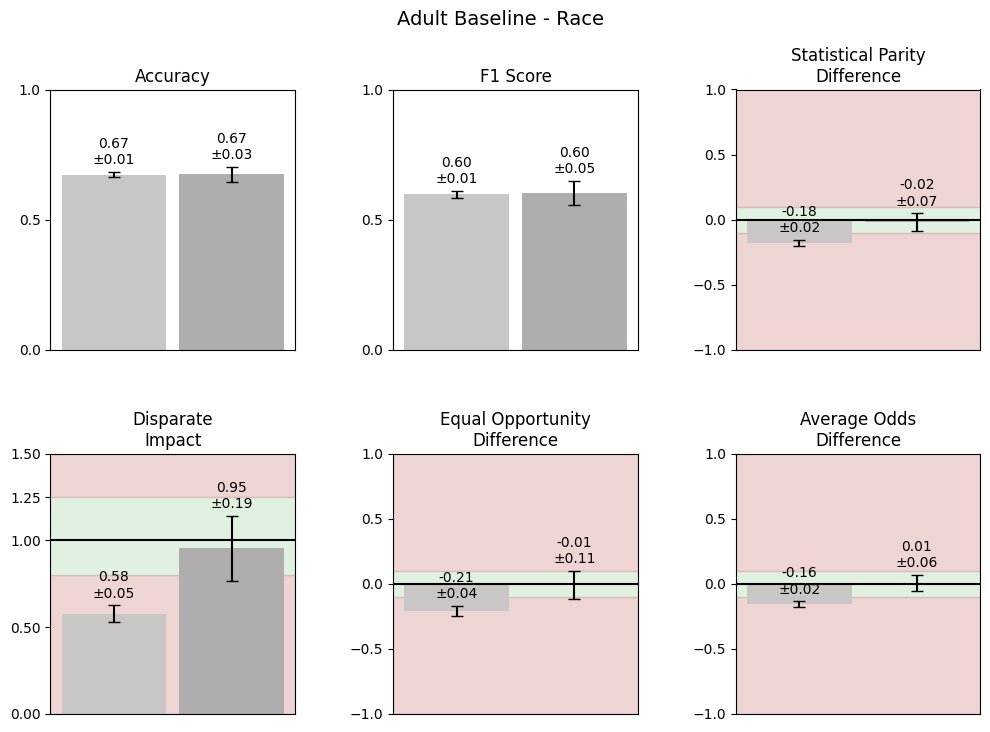

In [23]:
compare_viz_metrics_2x3(baseline_race_agg, final_df.agg(['mean','std']), 'Baseline', 'Race', 'Adult Baseline - Race')